# 1D Kernel Density Estimation

In [16]:
%matplotlib inline
import numpy as np
from scipy import stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
from statsmodels.distributions.mixture_rvs import mixture_rvs
from statsmodels.kernel_methods import bandwidths, kde_1d

## A simple example

To start with, we'll look at estimating the density of a mixture of gaussian kernels, just to see the simplest use case.

In [2]:
np.random.seed(12345)

In [3]:
obs_dist1 = mixture_rvs([.25,.75], size=10000, dist=[stats.norm, stats.norm],
                kwargs = (dict(loc=-1,scale=.5),dict(loc=1,scale=.5)))

In [4]:
kde = sm.kernel_methods.KDE(obs_dist1)
mod = kde.fit()
support, density = mod.grid()
mod.bandwidth

0.169553949046743

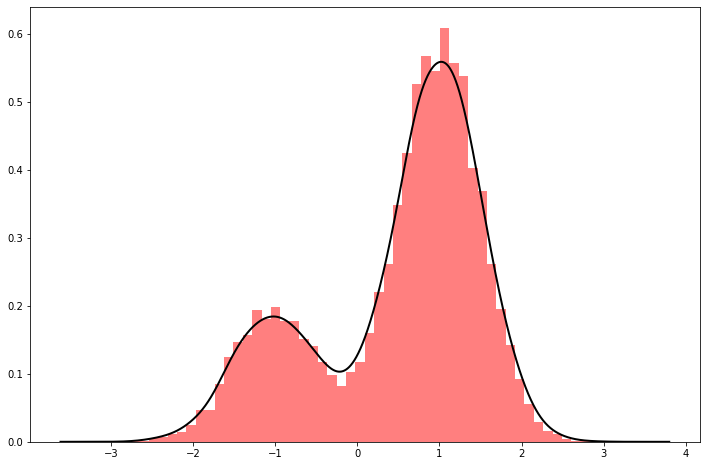

In [5]:
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111)
ax.hist(obs_dist1, bins=50, density=True, color='red', alpha=.5)
ax.plot(support, density, lw=2, color='black');

## Bounded domain

As a second example, we will look at a mixture between a normal and beta distribution, such that the domain is bounded on one side.

In [6]:
obs_dist2 = mixture_rvs([.25,.75], size=10000, dist=[stats.norm, stats.beta],
            kwargs = (dict(loc=-1,scale=.5),dict(loc=1,scale=1,args=(1,.5))))
def pdf_dist2(x):
    return stats.norm(loc=-1, scale=.5).pdf(x) *.25 + stats.beta(1, .5, loc=1, scale=1).pdf(x)*.75

First, let's see what happens if we don't mention the upper bound on the beta distribution:

In [7]:
kde = sm.kernel_methods.KDE(obs_dist2)
mod = kde.fit()

In [8]:
xs1, ys1 = mod.grid()
xs1

<Grid 65536R, [-3.29781 - 2.54359], dtype=float64>

We can see that, naturally, the expected support of the distribution extend beyond the support of the beta distribution (in our case, it stops at 2). And we can see in the following plot that the peak is badly estimated:

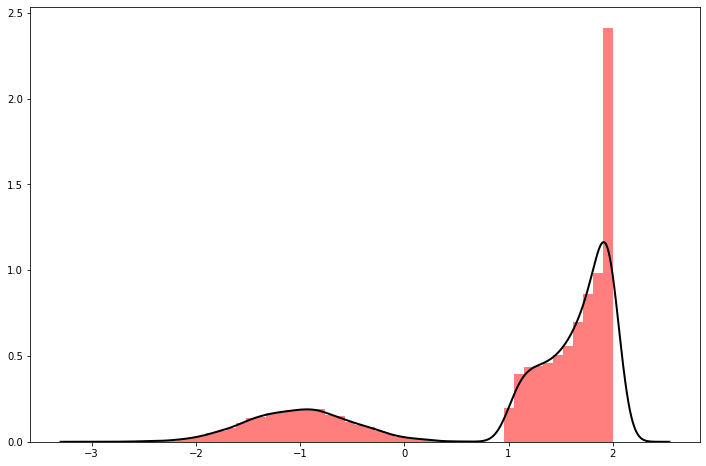

In [9]:
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111)
ax.hist(obs_dist2, bins=50, density=True, color='red', alpha=.5)
ax.plot(xs1, ys1, lw=2, color='black')

We can also see that stopping the domain at 2 on the evaluation, we "loose" some mass in the density (nearly 10% of it):

In [10]:
gr = sm.kernel_methods.Grid.fromBounds([-4, 2], shape=1024)
ys = mod(gr)
print("Sum of the density:", gr.integrate(ys))

Sum of the density: 0.89959630173442


Now, if we fix the upper bound ... we don't loose any more mass

In [11]:
kde.upper = 2
mod2 = kde.fit()

In [12]:
xs2, ys2 = mod2.grid()
print("Total density:", xs2.integrate(ys2))
xs2

Total density: 0.9999999999999989


<Grid 65536R, [-3.29781 - 2], dtype=float64>

(0, 4)

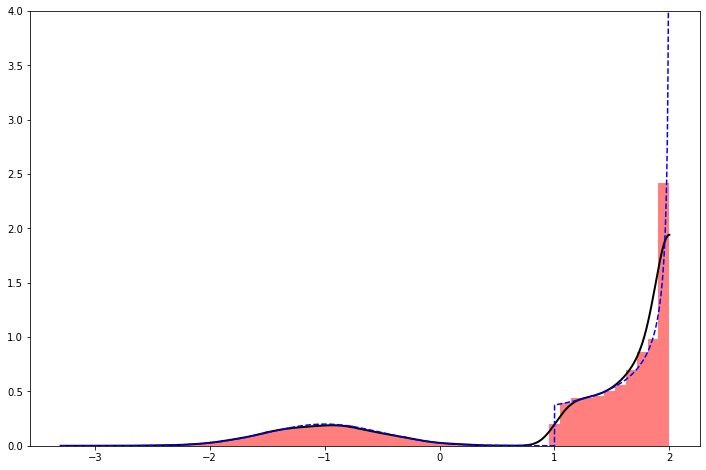

In [13]:
fig = plt.figure(figsize=(12, 8))
ax = fig.gca()
ax.hist(obs_dist2, bins=50, density=True, color='red', alpha=.5)
ax.plot(xs2, ys2, lw=2, color='black')
ax.plot(xs2, pdf_dist2(xs2), color='blue', linestyle='--')
ax.set_ylim(0, 4)

However, we can see that the peak, although better estimated, is still largely under-estimated by this method!

This is because the default method has been chosen to be fast and reasonable is many cases, but not if the distribution diverges on the boundary. For this case, a better method is the first order approximation called 'linear combination':

In [17]:
kde.method = kde_1d.LinearCombination
mod3 = kde.fit()

In [18]:
xs3, ys3 = mod3.grid()
print("Total density: ", xs3.integrate(ys3))  # Using the integrate method of the Grid object

Total density:  1.0511718138987112


You can note that, due to the first order approximation, the total density is not quite 1. In this particular case, it is over-estimated by about 5%. But when we plt the graph, we can see that the peak is much better approximated now:

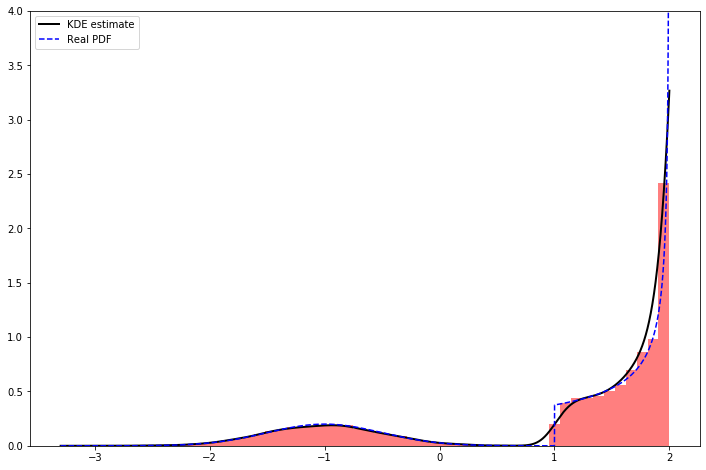

In [19]:
fig = plt.figure(figsize=(12, 8))
ax = fig.gca()
ax.hist(obs_dist2, bins=50, density=True, color='red', alpha=.5)
ax.plot(xs3, ys3, lw=2, color='black', label='KDE estimate')
ax.plot(xs3, pdf_dist2(xs3), color='blue', linestyle='--', label='Real PDF')
ax.set_ylim(0, 4)
plt.legend(loc='best')

At last, we can see the bandwidth is slightly over-estimated. We could expect this, as the default method is Scotts method, which is optimal for a single gaussian. In our case, the extra beta function will lead to an over-estimation of the ideal bandwidth. We can, however, do this by hand:

In [20]:
kde.adjust = 0.5
mod4 = kde.fit()
xs4, ys4 = mod4.grid()
print("Total density: ", xs4.integrate(ys4))

Total density:  1.0366810472995898


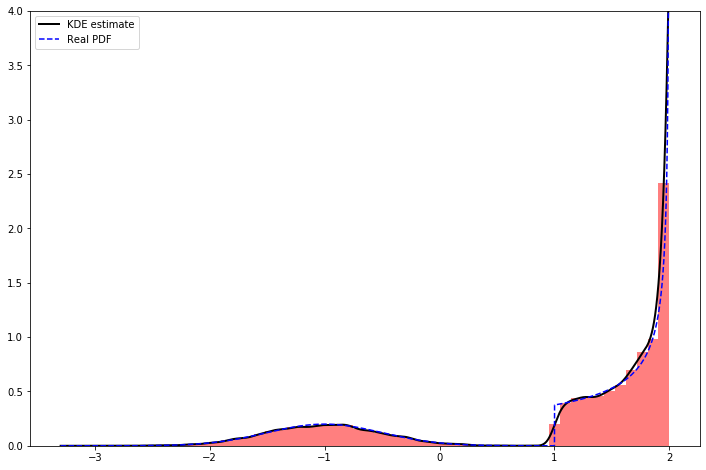

In [21]:
fig = plt.figure(figsize=(12, 8))
ax = fig.gca()
ax.hist(obs_dist2, bins=50, density=True, color='red', alpha=.5)
ax.plot(xs4, ys4, lw=2, color='black', label='KDE estimate')
ax.plot(xs4, pdf_dist2(xs4), color='blue', linestyle='--', label='Real PDF')
ax.set_ylim(0, 4)
plt.legend(loc='best')

(0, 3)

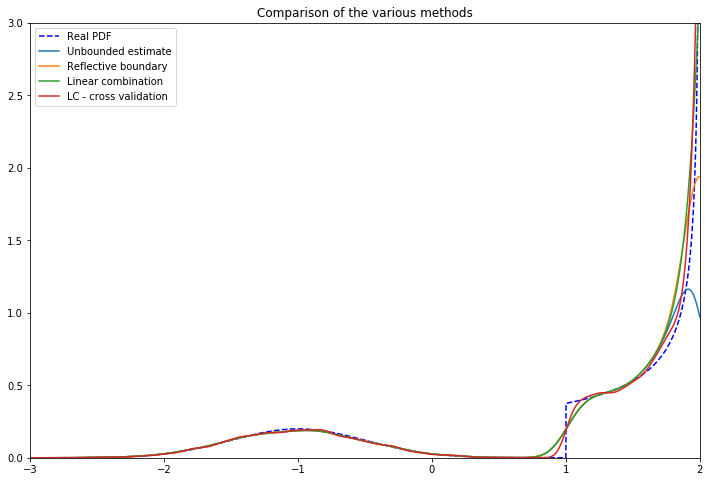

In [22]:
fig = plt.figure(figsize=(12, 8))
ax = fig.gca()
ax.plot(xs4, pdf_dist2(xs4), label='Real PDF', color='blue', linestyle='--')
ax.plot(xs1, ys1, label='Unbounded estimate')
ax.plot(xs2, ys2, label='Reflective boundary')
ax.plot(xs3, ys3, label='Linear combination')
ax.plot(xs4, ys4, label='LC - cross validation')
plt.legend(loc='upper left')
ax.set_title('Comparison of the various methods')
ax.set_xlim(-3, 2)
ax.set_ylim(0, 3)

## Other functions

In addition to the PDF, 1D methods also provide:

* Cumulative Density Function
* Survival function
* Hazard function
* ...

Text(0.5, 1.0, 'CDF')

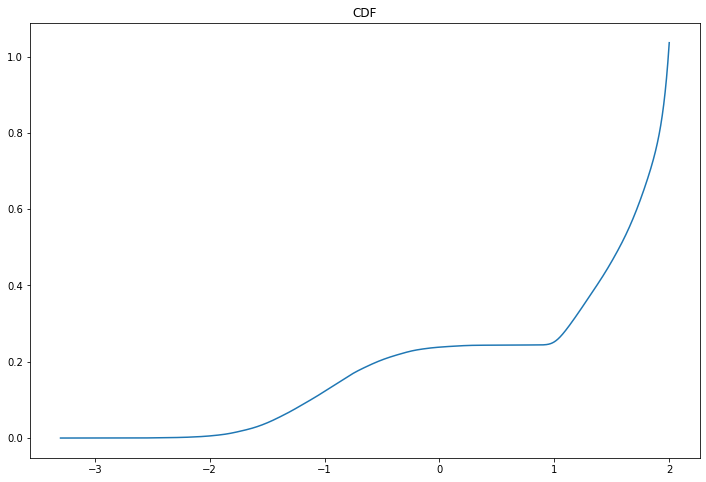

In [23]:
xs, ys = mod4.cdf_grid()
f = plt.figure(figsize=(12, 8))
ax = f.add_subplot(111)
ax.plot(xs, ys)
ax.set_title('CDF')

Text(0.5, 1.0, 'Survival function')

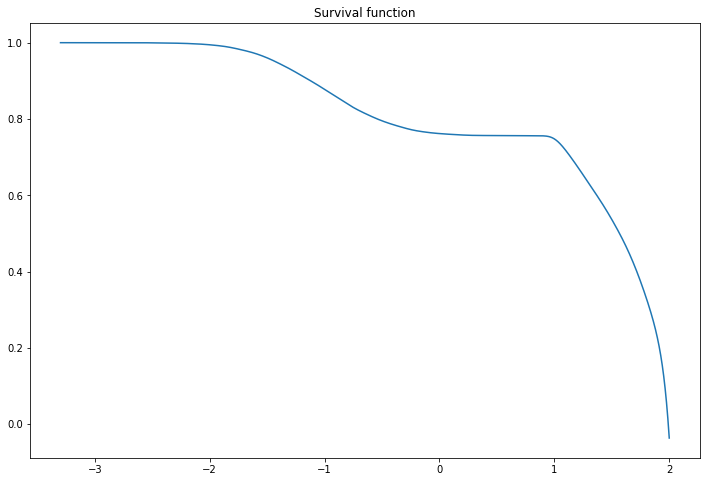

In [24]:
xs, ys = mod4.sf_grid()
f = plt.figure(figsize=(12, 8))
ax = f.add_subplot(111)
ax.plot(xs, ys)
ax.set_title('Survival function')

Text(0.5, 1.0, 'Inverse CDF')

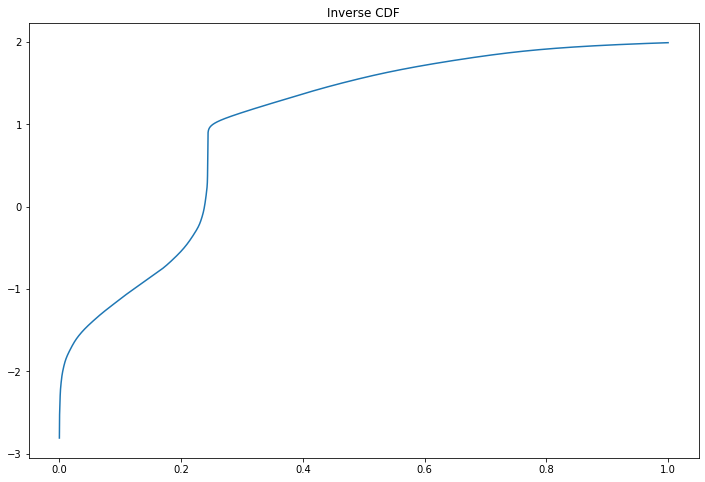

In [25]:
xs, ys = mod4.icdf_grid()
f = plt.figure(figsize=(12, 8))
ax = f.add_subplot(111)
ax.plot(xs, ys)
ax.set_title('Inverse CDF')